In [1]:
!ls

classifiers_mhcld.ipynb
codebook_descriptions.pickle
deep_learning.ipynb
google_colab_t-sne_mental_health_client-level_data.ipynb
mhcld_puf_2021.csv
plots
t-sne_k-means_mhcld.ipynb
to_do.txt
unsupervised_learning.ipynb


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
NUM_POINTS = 100_000
data = pd.read_csv("mhcld_puf_2021.csv")
data = data[:NUM_POINTS]

In [4]:
# Load data the codebook descriptions
import pickle
with open('codebook_descriptions.pickle', 'rb') as handle:
    codebook_descriptions = pickle.load(handle)
assert set(list(data.columns)) == set(list(codebook_descriptions.keys()))

In [52]:
#columns to drop. reasoning in t-sne notebook.
drop_cols = ['YEAR','CASEID','MH1','MH2','MH3','SMISED','DETNLF','NUMMHS','STATEFIP','REGION','DIVISION']
data = data.drop(columns = drop_cols)

In [54]:
#disorder columns. 0/1 binary. these are dignoses for the disorders. 14 total
disorder_cols = ['SUB','TRAUSTREFLG','ANXIETYFLG','ADHDFLG','CONDUCTFLG','DELIRDEMFLG','BIPOLARFLG','DEPRESSFLG','ODDFLG','PDDFLG','SCHIZOFLG','PERSONFLG','ALCSUBFLG','OTHERDISFLG']

In [79]:
#columns which require a transformation to standardize to 0-1. reasoning in t-sne notebook.
transform_cols = ['AGE','EDUC','GENDER','SUB','SPHSERVICE','CMPSERVICE','OPISERVICE','RTCSERVICE','IJSSERVICE','SAP','VETERAN ']
max_age = max(data['AGE'])
max_educ = max(data['EDUC'])
data['AGE'] = data['AGE'].apply(lambda x: x/max_age)
data['EDUC'] = data['EDUC'].apply(lambda x: 0 if x==-9 else x/max_educ)
data['GENDER'] = data['GENDER'].apply(lambda x: .5 if x==-9 else x-1)
data['SUB'] = data['SUB'].apply(lambda x: 0 if x==-9 else 1)
data['SAP'] = data['SAP'].apply(lambda x: .5 if x==-9 else x-1)
data['VETERAN'] = data['VETERAN'].apply(lambda x: .5 if x==-9 else x-1)
data['SPHSERVICE'] = data['SPHSERVICE'].apply(lambda x: x-1)
data['CMPSERVICE'] = data['CMPSERVICE'].apply(lambda x: x-1)
data['OPISERVICE'] = data['OPISERVICE'].apply(lambda x: x-1)
data['RTCSERVICE'] = data['RTCSERVICE'].apply(lambda x: x-1)
data['IJSSERVICE'] = data['IJSSERVICE'].apply(lambda x: x-1)

In [56]:
#categorical columns w/ more than two categorices
#encode them with one-hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_cols = ['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']
one_hot_enc=OneHotEncoder().fit(data[one_hot_cols])
one_hot_categorical_data = one_hot_enc.transform(data[one_hot_cols]).toarray()
one_hot_feature_names=list(one_hot_enc.get_feature_names_out(['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']))
one_hot_encoded_df = pd.DataFrame(data=one_hot_categorical_data,columns=one_hot_feature_names)
print(sum(len(item) for item in one_hot_enc.categories_))
data = data.drop(columns=one_hot_cols)
data = data.join(one_hot_encoded_df)
print(data.shape)

26
(100000, 50)


In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [81]:
model = Sequential()
model.add(Dense(10, input_shape=(36,), activation='relu'))
model.add(Dense(14, activation='relu'))

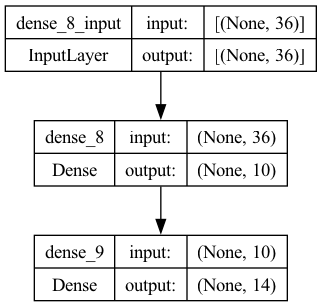

In [82]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [83]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
#drop disorder cols, we are predicting those
#use unique_disorder labels
X = data.drop(columns=disorder_cols)
y = np.squeeze(data[disorder_cols])

In [85]:
print(X.shape, y.shape)

(100000, 36) (100000, 14)


In [86]:
from sklearn.model_selection import train_test_split

In [87]:
# Split the data into training and test sets
#stratified k-fold didn't help much
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [90]:
# fit the keras model on the dataset
model.fit(X, y, epochs=2, batch_size=10)

Epoch 1/2
10000/10000 [==============================] - 49s 5ms/step - loss: 0.4074 - accuracy: 0.3180
Epoch 2/2
10000/10000 [==============================] - 45s 5ms/step - loss: 0.3341 - accuracy: 0.4133


In [91]:
model.predict(X_test[:1])

1/1 [==============================] - 0s 28ms/step


array([[0.        , 0.16150793, 0.29977372, 0.        , 0.        ,
        0.        , 0.1468912 , 0.46802765, 0.        , 0.        ,
        0.05724061, 0.17339405, 0.        , 0.0677651 ]], dtype=float32)

In [92]:
predictions = model.predict(X_test)
predictions_rounded = [[round(i) for i in a] for a in predictions]

625/625 [==============================] - 1s 1ms/step


In [93]:
from sklearn.metrics import hamming_loss, accuracy_score, precision_score
hamming_loss(predictions_rounded,y_test)

0.09829642857142858

In [122]:
#random guess would be 100_000/2^14 = 6.1%
#showing ~10.8%
#this is just the number of correct predictions. good! as expected
accuracy_score(predictions_rounded,y_test)

0.10815

In [123]:
#precision is quite high at 50%
#means model is making many 'true positive' classifications
#i.e. when it's a "1" classification, we can be more confident it's correct
precision_score(predictions_rounded,y_test,average='weighted')

0.5027130655937028